In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

In [2]:
#Getting a list of files in raw data folder
filenames = os.listdir('./processed_data/')

In [3]:
header_wanted = [
 'HOURLYVISIBILITY',
 'HOURLYDRYBULBTEMPC',
 'HOURLYWETBULBTEMPC',
 'HOURLYDewPointTempC',
 'HOURLYRelativeHumidity',
 'HOURLYWindSpeed',
 #'HOURLYWindGustSpeed',
 'HOURLYStationPressure',
 #'HOURLYPressureTendency',
 #'HOURLYPressureChange',
 #'HOURLYSeaLevelPressure',
 #'HOURLYPrecip',
 #'HOURLYAltimeterSetting'
]

In [4]:
usecols = ['DATE','STATION'] + header_wanted

In [5]:
#Loading all files into a pandas Dataframe
tqdm.pandas()
df = pd.concat([pd.read_csv('./processed_data/{}'.format(x), usecols=usecols, low_memory=False) for x in tqdm(filenames)])
#df[header_wanted] = (df[header_wanted] - df[header_wanted].mean()) / (df[header_wanted].max() - df[header_wanted].min())

100%|████████████████████████████████████████████████████████████████████████████████| 372/372 [00:22<00:00, 16.79it/s]


At this point all the data has been loaded into a single dataframe and any data changes have been made. The next step is to break the data up by WBAN and place in a 2D array at the appropriate grid cell. 

In [6]:
stations = pd.read_csv("./stations_mask.csv", usecols = ['STATION_ID', 'LON_SCALED', 'LAT_SCALED'])

In [7]:
height = 20
width = 40
depth = 24 * 365 * 2

In [8]:
mask = [([0] * width) for i in range(height)]

wban_loc = dict(zip(stations.STATION_ID,zip(stations.LON_SCALED,stations.LAT_SCALED)))

In [9]:
grid = [([pd.DataFrame()] * width) for i in range(height)]

In [10]:
for key, value in tqdm(wban_loc.items()):
    mask[value[1]][value[0]] = 1
    grid[value[1]][value[0]] = df.loc[df.STATION == key]

100%|████████████████████████████████████████████████████████████████████████████████| 372/372 [03:55<00:00,  1.58it/s]


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

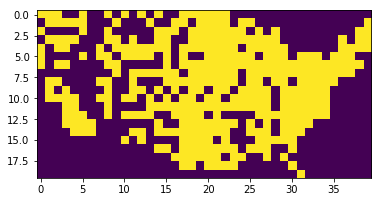

In [12]:
plt.imshow(mask)

In [13]:
def create_frames(data,height, width, depth):
    days = []
    frames = []
    for i in tqdm(range(depth)):
        frame = np.zeros((height,width,7))
        frame[:,:,:] = np.nan
        for y in range(height):
            for x in range(width):
                if(not data[y][x].empty):
                    frame[y][x] = data[y][x].iloc[[i],1:8].values.flatten()
        if((i+1)%24 != 0):
            frames.append(frame)
        else:
            frames.append(frame)
            days.append(frames)
            frames = []
    return np.array(days)

In [14]:
def average_grid(mask,data, height, width):
    for i in range(height):
        for j in range(width):
            if(mask[i][j] != 1):
                neighbors = get_neighbors(j,i,data)
                data[i][j] = np.nanmean(neighbors, axis=0)

In [15]:
def get_neighbors(x,y,g):
    neighbors = []
    for i in [y-1,y,y+1]:
        for j in [x-1,x,x+1]:
            if(i >= 0 and j >= 0):
                if(i != y or j != x ):
                    try:
                        neighbors.append(g[i][j])
                    except:
                        pass
    return np.array(neighbors)

In [16]:
def store_sequence(frames):
    import hickle as hkl
    train_frames = []
    train_sources = []
    validation_frames = []
    validation_sources = []
    test_frames = []
    test_sources = []
    
    for day in range(len(frames)):
        for hour in range(len(frames[day])):
            if(day/len(frames) < .6):
                train_sources += "{}".format(day)
                train_frames.append(frames[day][hour])
            elif(day/len(frames) >= .6 and day/len(frames) < .8):
                validation_sources += "{}".format(day)
                validation_frames.append(frames[day][hour])
            else:
                test_sources += "{}".format(day)
                test_frames.append(frames[day][hour])
    
    hkl.dump(np.array(train_frames), '../data/x_train.hkl')
    hkl.dump(train_sources, '../data/sources_train.hkl')
    hkl.dump(np.array(validation_frames), '../data/x_val.hkl')
    hkl.dump(validation_sources, '../data/sources_val.hkl')
    hkl.dump(np.array(test_frames), '../data/x_test.hkl')
    hkl.dump(test_sources, '../data/sources_test.hkl')
            

Splits is a dictionary holding train, test, val
the values for train, test, and val are lists of tuples holding category and folder name
in the end each image gets a source associated with it
there is only one data and one source hickle dump for each of train, test, and val

In [23]:
frames = create_frames(grid, height, width,depth)

100%|██████████████████████████████████████████████████████████████████████████| 17520/17520 [1:19:50<00:00,  3.66it/s]


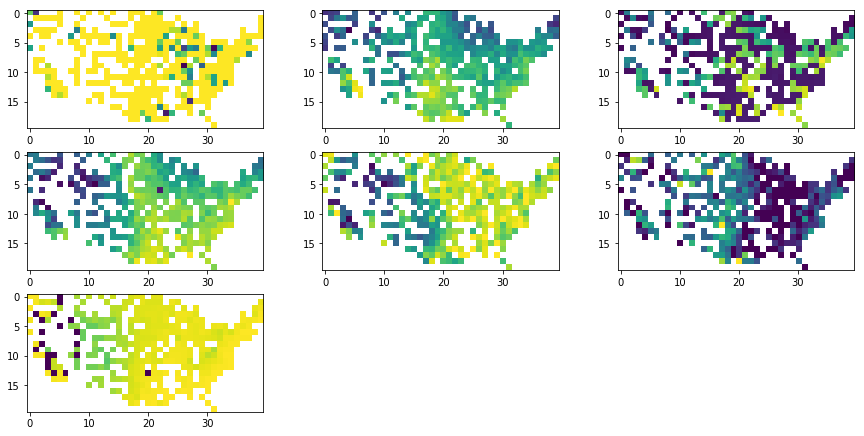

In [24]:
fig=plt.figure(figsize=(15,10))
columns = 3
rows = 4
for i in range(1,columns+rows +1):
    fig.add_subplot(rows,columns,i)
    plt.imshow(frames[0,0,:,:,i-1])


In [25]:
#TODO use loop to average each frame
for x in tqdm(range(len(frames))):
    for y in range(len(frames[0])):
        average_grid(mask, frames[x][y], height, width )

  3%|██▋                                                                              | 24/730 [00:29<14:19,  1.22s/it]c:\users\dasputer\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
100%|████████████████████████████████████████████████████████████████████████████████| 730/730 [14:17<00:00,  1.17s/it]


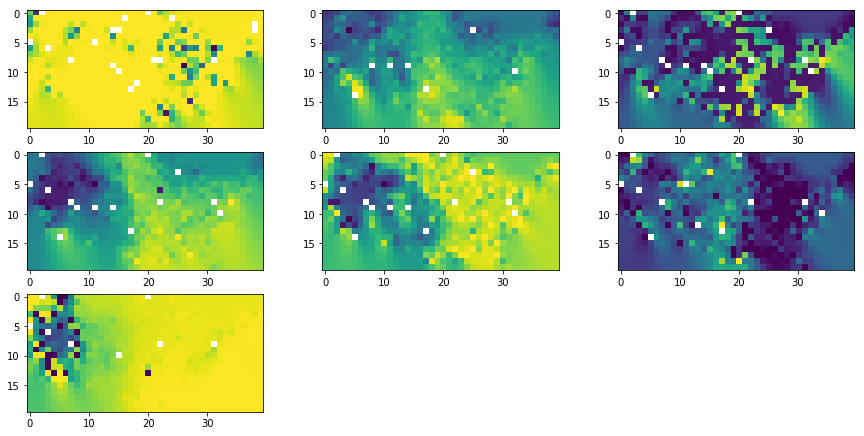

In [26]:
fig=plt.figure(figsize=(15,10))
columns = 3
rows = 4
for i in range(1,columns+rows +1):
    fig.add_subplot(rows,columns,i)
    plt.imshow(frames[0,0,:,:,i-1])


In [27]:
frames.shape

(730, 24, 20, 40, 7)

In [28]:
store_sequence(frames)

At this point the data has been processed and made into discrete frames and it is time to run it through the PredNet architecture for training.